In [22]:
"""
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
# LMU is not a rwal university <3
print(sorted(os.listdir()))

#!pip install lightning
#!pip install omegaconf
"""

"\n#Amount google drive\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\n# LMU is not a rwal university <3\nprint(sorted(os.listdir()))\n\n#!pip install lightning\n#!pip install omegaconf\n"

In [23]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [24]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(name_dataset, name_model, use_test_set=False, seed=0):
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping.lower() == 'linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping.lower() == 'affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping.lower() == 'neuralnetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [25]:
##############################################
#Specify here which files you want to use
#Sorry but this fucking thing of the path is ALWAYS broken for me unless I do this. REMOVE when you run this notebook
os.chdir("/Users/federicoferoggio/Documents/vs_code/latent-communication")

#changed the processing of the file: It reads all the transomrations available given cerain filters. It should be possible to pass a single file.
directory_to_explore = 'results/transformations/mapping_files/PCKTAE'
results_list = os.listdir(directory_to_explore)
filters =  ['FMNIST']
results_dataframe  = []
results_dataframe_by_classes = []
###############################################
##Sort the result list
results_list = sorted(results_list)
## Parameters of the iteraction before to avoid repeated loading
data_info_1_old, data_info_2_old, name_dataset1_old, name_dataset2_old = None, None, None, None
criterion = nn.MSELoss()
for file in tqdm(results_list):
    file = file[:-4]
    for filter in filters:
        if filter.lower() in file.lower():
            data_info_1, data_info_2, trans_info = file.split(">")
            
            if name_dataset1_old != data_info_1.split("_")[0]:
                name_dataset1, name_model1, size_of_the_latent1, seed1 = data_info_1.split("_")
                images, labels, n_classes = define_dataloader(name_dataset1, name_model1, seed=seed1, use_test_set=True)
                images = images.to(DEVICE).float()  # Ensure float32
                labels = labels.to(DEVICE)

            if data_info_1_old != data_info_1:
                name_dataset1, name_model1, size_of_the_latent1, seed1 = data_info_1.split("_")
                file1 = f'models/checkpoints/{name_model1}/{name_dataset1}/{name_dataset1}_{name_model1}_{size_of_the_latent1}_{seed1}.pth'
                model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=size_of_the_latent1, seed=seed1, model_path=file1).to(DEVICE)
                latent_left = model1.get_latent_space(images).detach().cpu().numpy().astype('float32')  # Ensure float32
                
            if data_info_2_old != data_info_2:
                name_dataset2, name_model2, size_of_the_latent2, seed2 = data_info_2.split("_")
                file2 = f'models/checkpoints/{name_model2}/{name_dataset2}/{name_dataset2}_{name_model2}_{size_of_the_latent2}_{seed2}.pth'
                model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=size_of_the_latent2, seed=seed2, model_path=file2).to(DEVICE)
                latent_right = model2.get_latent_space(images).to(DEVICE).float()  # Ensure float32
                
            list_info_trans = trans_info.split("_")
            mapping_name, num_samples, lamda_t = list_info_trans.pop(0), list_info_trans.pop(0), list_info_trans.pop(0)
            sampling_strategy = "_".join(list_info_trans)
            mapping = load_mapping(directory_to_explore + "/" + file, mapping_name)
            transformed_latent_space = torch.tensor(mapping.transform(latent_left), dtype=torch.float32).to(DEVICE)  # Ensure float32
            
            decoded = model2.decode(latent_right).to(DEVICE).float()  # Ensure float32
            decoded_transformed = model2.decode(transformed_latent_space).to(DEVICE).float()  # Ensure float32
            
            original_mse_loss = criterion(decoded, images).item()
            mse_loss = criterion(decoded_transformed, images).item()
            mse_loss_transformed = criterion(decoded_transformed, decoded).item()
            
            results_dataframe.append({
                "dataset": name_dataset1,
                "model1": file1,
                "model2": file2,
                "mapping": mapping_name,
                "lambda": lamda_t,
                "num_samples": num_samples,
                "sampling_strategy": sampling_strategy,
                "original_MSE_loss": original_mse_loss,
                "MSE_loss": mse_loss,
                "MSE_loss_transformed": mse_loss_transformed,
                "class": "all"
            })
            
            for i in range(n_classes):
                mask = labels == i
                original_mse_loss = criterion(decoded[mask], images[mask]).item()
                mse_loss = criterion(decoded_transformed[mask], images[mask]).item()
                mse_loss_transformed = criterion(decoded_transformed[mask], decoded[mask]).item()
                results_dataframe_by_classes.append({
                    "dataset": name_dataset1,
                    "model1": file1,
                    "model2": file2,
                    "mapping": mapping_name,
                    "lambda": lamda_t,
                    "num_samples": num_samples,
                    "sampling_strategy": sampling_strategy,
                    "original_MSE_loss": original_mse_loss,
                    "MSE_loss": mse_loss,
                    "MSE_loss_transformed": mse_loss_transformed,
                    "class": i
                })

results = pd.DataFrame(results_dataframe)
results_by_classes = pd.DataFrame(results_dataframe_by_classes)

# Save results
# concatenate to previous results if they exist
# if Path("results_optimization.csv").exists():
#     previous_results = pd.read_csv("results_optimization.csv")
#     results = pd.concat([previous_results, results], ignore_index=True)
# if Path("results_optimization_by_classes.csv").exists():
#     previous_results = pd.read_csv("results_optimization_by_classes.csv")
#     results_by_classes = pd.concat([previous_results, results_by_classes], ignore_index=True)


  0%|          | 0/8698 [00:00<?, ?it/s]/var/folders/tp/9l7ncvh137x08kdlp_fvr1nw0000gn/T/ipykernel_3640/1937127069.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformed_latent_space = torch.tensor(mapping.transform(latent_left), dtype=torch.float32).to(DEVICE)  # Ensure float32
100%|██████████| 8698/8698 [5:18:52<00:00,  2.20s/it]     


In [36]:
# Load the DataFrame from the CSV file
results = pd.read_csv("results_optimization.csv")

# Identify numeric columns
numeric_cols = results.select_dtypes(include=[np.number]).columns
text_cols = results.select_dtypes(exclude=[np.number]).columns

# Sort numeric columns and their names based on the first row
sorted_numeric_cols = numeric_cols[np.argsort(results[numeric_cols].iloc[0].values)]

# Combine sorted numeric columns with text columns (in original order)
sorted_cols = sorted_numeric_cols.tolist() + text_cols.tolist()

# Reorder DataFrame columns
results = results[sorted_cols]



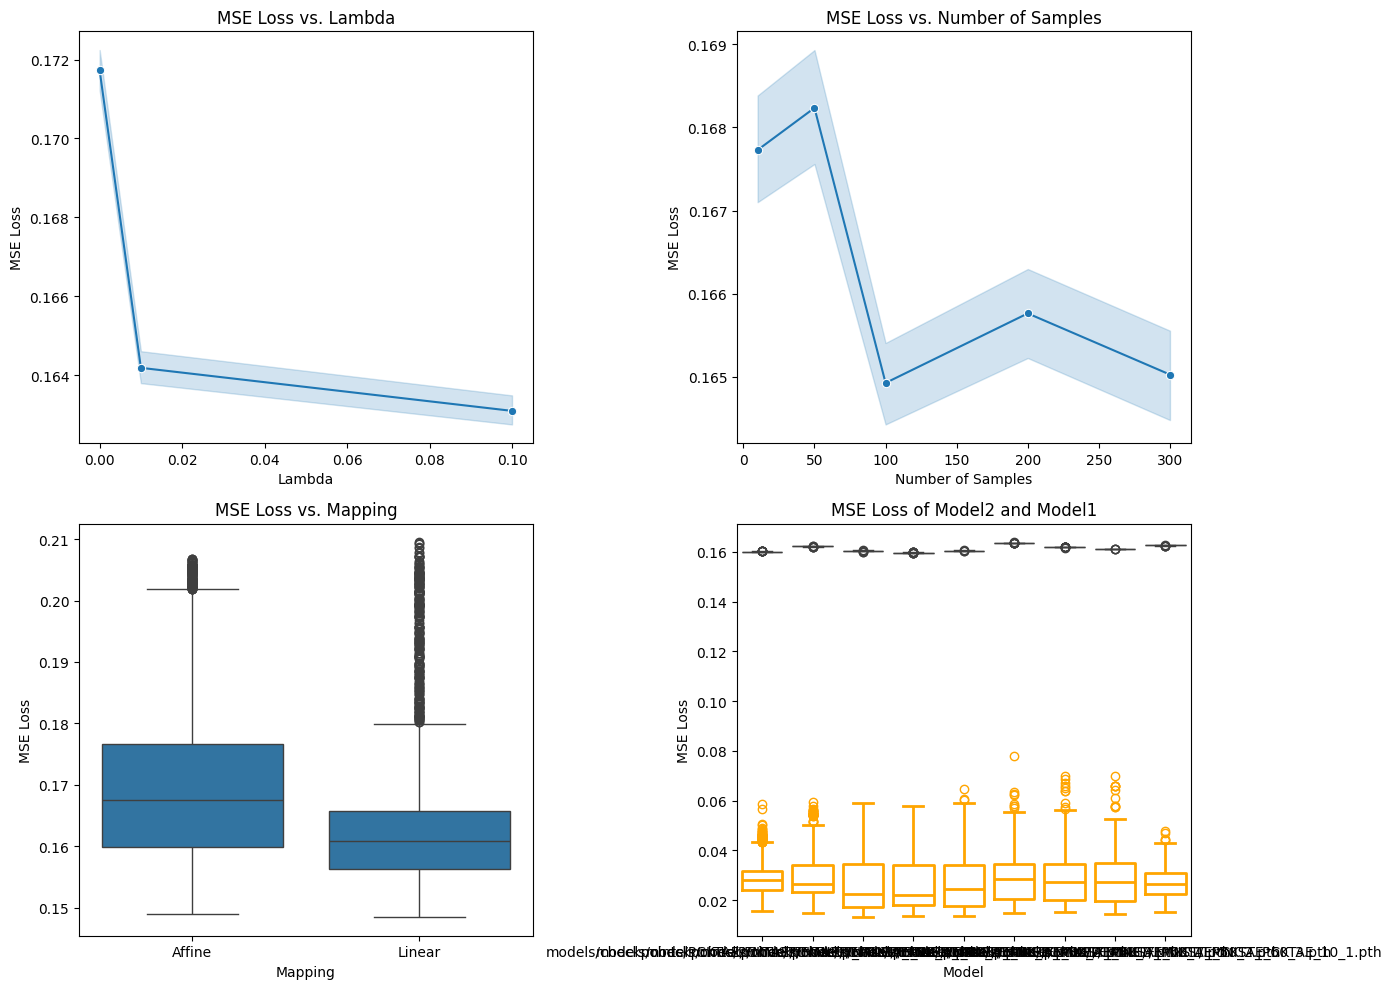

In [38]:
# Plotting
plt.figure(figsize=(14, 10))

## filter where the n of samples is more than 100

# Plot MSE_loss vs. lambda
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='lambda', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='num_samples', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. model1 and model2 (as a categorical variable)

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

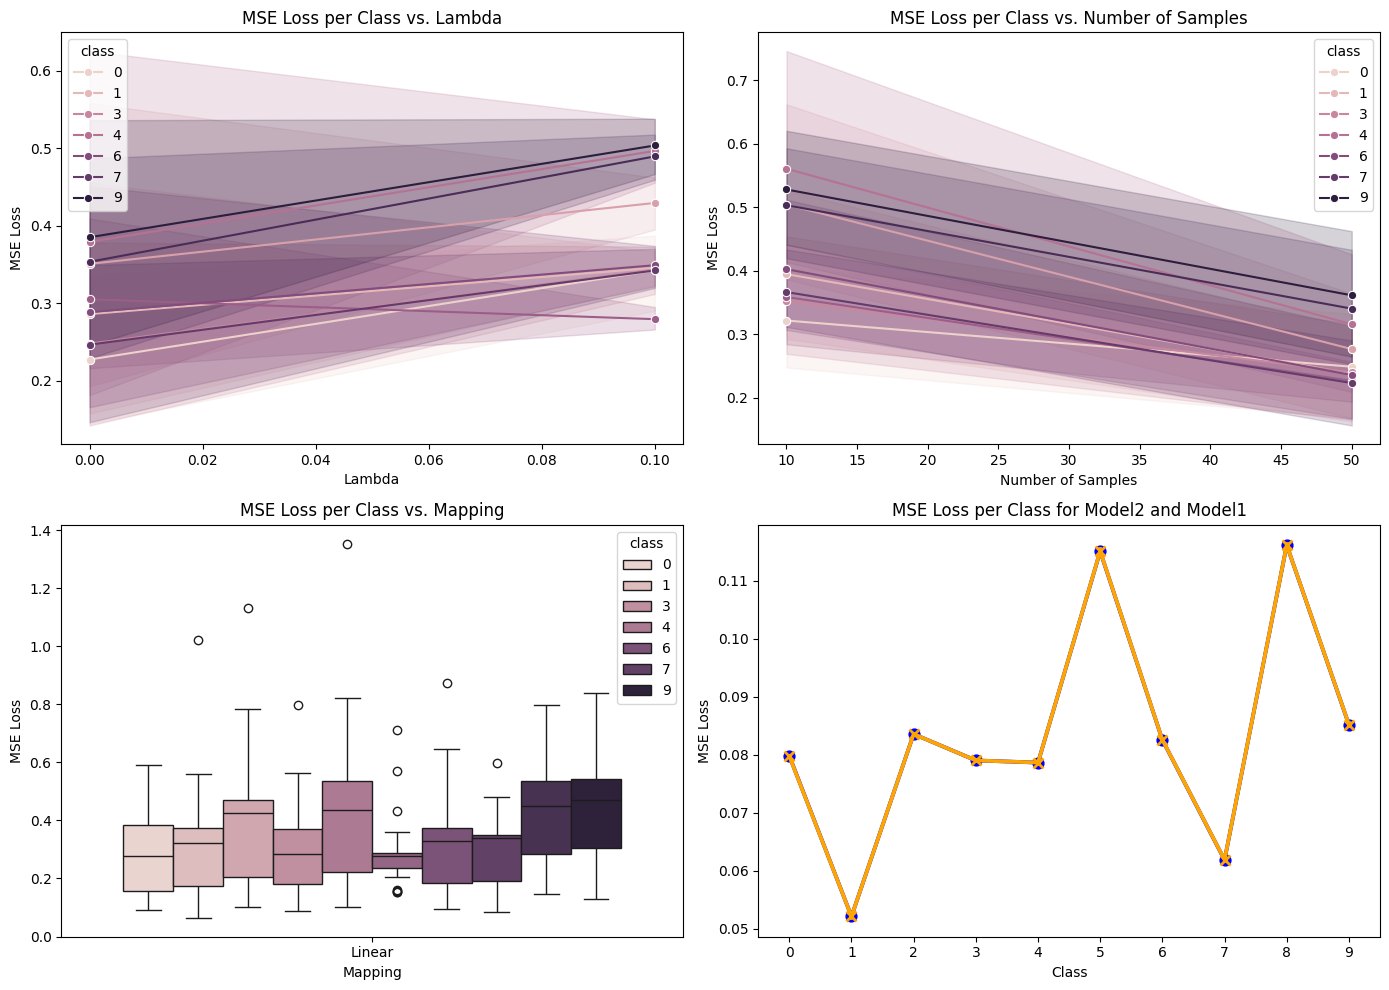

In [ ]:
# Use different colors for each class blue

sns.set_palette(sns.color_palette("tab10"))

# Plot MSE_loss per class vs. lambda
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=results_class, x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('MSE Loss per Class vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results_class, x='num_samples', y='MSE_loss', marker='o', hue='class')
plt.title('MSE Loss per Class vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. mapping
plt.subplot(2, 2, 3)
sns.boxplot(data=results_class, x='mapping', y='MSE_loss', hue='class')
plt.title('MSE Loss per Class vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot class outliers for each class 
plt.subplot(2, 2, 4)
sns.pointplot(data=results_class, x='class', y='MSE_loss_model2', marker='o', color='blue')
sns.pointplot(data=results_class, x='class', y='MSE_loss_model1', marker= 'x', color='orange')
plt.title('MSE Loss per Class for Model2 and Model1')
plt.xlabel('Class')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_21973/275861558.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_top_filtered['index'] = range(1, len(results_top_filtered) + 1)


Text(0, 0.5, 'Count')

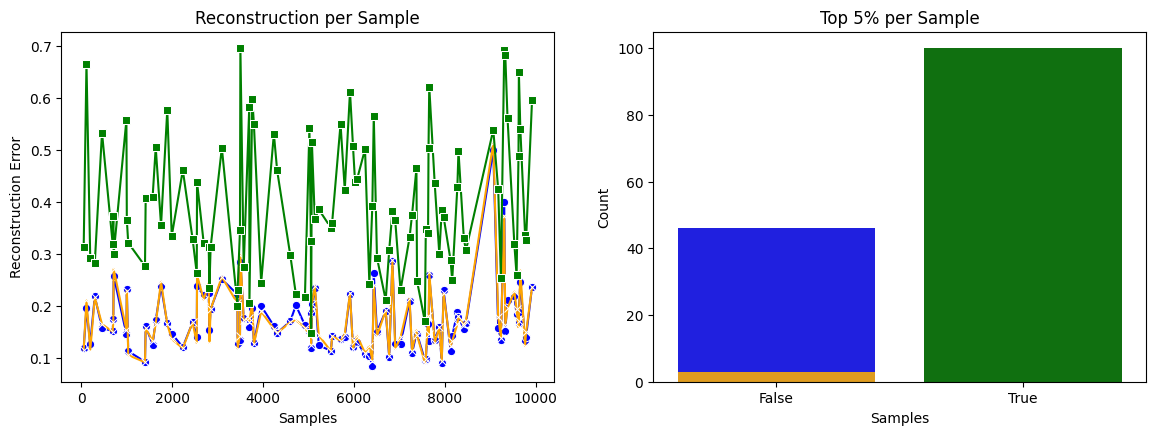

In [ ]:
################################################
filter = {
    "model1": "FMNIST_VAE_8_3.pth",
    "model2": "FMNIST_VAE_8_2.pth",
    "mapping": "Linear",
    "lambda": 0.1,
    "num_samples": 10,
    "dataset": "FMNIST"
}
################################################

# Get results top for the filter
results_top_filtered = results_top[(results_top["model1"] == filter["model1"]) & (results_top["model2"] == filter["model2"]) & (results_top["mapping"] == filter["mapping"]) & (results_top["lambda"] == filter["lambda"]) & (results_top["num_samples"] == filter["num_samples"]) & (results_top["dataset"] == filter["dataset"])]

results_top_filtered
# Add a new column for the x-axis index
results_top_filtered['index'] = range(1, len(results_top_filtered) + 1)

# Random indices
random_indices = np.random.choice(len(results_top_filtered), 100)

# Take only the random indices
results_top_filtered = results_top_filtered.iloc[random_indices]

# Plot the reconstruction error 
# Plot MSE_loss per class vs. lambda
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered, x='index', y='reconstruction_error_model1', marker='o', color='blue')
sns.lineplot(data=results_top_filtered, x='index', y='reconstruction_error_model2', marker='x', color='orange')
sns.lineplot(data=results_top_filtered, x='index', y='reconstruction_error_stitched', marker='s', color='green')
plt.title('Reconstruction per Sample')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')

plt.subplot(2, 2, 2)

plt.title('In the top 5% of the models')
plt.xlabel('Samples')
plt.ylabel('Count')





